In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc

In [166]:
# Import the CSV file named 'water_potability.csv' into a pandas DataFrame
df = pd.read_csv("water_potability.csv")

# Display the first five rows of the DataFrame to preview the data
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [167]:
# Display a concise summary of the DataFrame, including:
# - Number of rows and columns
# - Column names and data types
# - Non-null counts for each column (to check missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [168]:
# Get the dimensions of the DataFrame `df` as (number of rows, number of columns)
df.shape

(3276, 10)

In [169]:
# Summary statistics (count, mean, std, min, max, quartiles) of numeric columns
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [170]:
# Print the count of missing (NaN) values in each column of the DataFrame
print(df.isna().sum())

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [171]:
# Print the total number of duplicate rows in the DataFrame
print(df.duplicated().sum())

0


In [172]:
# Initialize a dictionary to store the outlier count for each column
count_outlier = {}

# Loop through each column in the DataFrame
for col in df.columns:
    # Calculate the 25th percentile (Q1) of the column
    q1 = df[col].quantile(.25)
    # Calculate the 75th percentile (Q3) of the column
    q3 = df[col].quantile(.75)

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Define the upper whisker for outlier detection
    upper_whisker = q3 + 1.5 * iqr
    # Define the lower whisker for outlier detection
    lower_whisker = q1 - 1.5 * iqr

    # Identify outliers as values outside the whiskers
    counts = (df[col] > upper_whisker) | (df[col] < lower_whisker)
    # Store the count of outliers for this column
    count_outlier[col] = counts.sum()

# Convert the outlier counts dictionary into a DataFrame for display
outlier_df = pd.DataFrame(
    {
        'Columns': count_outlier.keys(),       # Column names
        'Outlier Count': count_outlier.values() # Corresponding outlier counts
    }
)

# Display the DataFrame showing outlier counts per column
outlier_df

,Columns,Outlier Count
0,ph,46
1,Hardness,83
2,Solids,47
3,Chloramines,61
4,Sulfate,41
5,Conductivity,11
6,Organic_carbon,25
7,Trihalomethanes,33
8,Turbidity,19
9,Potability,0


In [173]:
# Create a copy of the original DataFrame to keep the original data unchanged
df_copy = df.copy()

# Define different IQR multipliers to test outlier removal strength
iqr_factors = [1, 1.5, 2, 2.5, 3]

# Initialize a list to store results for each IQR factor
result = []

# Loop through each IQR factor
for k in iqr_factors:
    # Create a temporary copy of the DataFrame for current IQR factor
    df_temp = df_copy.copy()

    # Loop through only numerical columns for outlier detection
    for col in df_temp.select_dtypes(include='number'):
        # Calculate the first quartile (Q1) of the column
        q1 = df_temp[col].quantile(.25)
        # Calculate the third quartile (Q3) of the column
        q3 = df_temp[col].quantile(.75)

        # Compute the interquartile range (IQR)
        iqr = q3 - q1
        
        # Define the upper boundary for outlier removal
        upper_whisker = q3 + k * iqr
        # Define the lower boundary for outlier removal
        lower_whisker = q1 - k * iqr

        # Remove rows containing outliers based on current column and IQR factor
        df_temp = df_temp[
            (df_temp[col] <= upper_whisker) & 
            (df_temp[col] >= lower_whisker)
        ]

    # Calculate how many rows were removed after outlier filtering
    row_removed = len(df_copy) - len(df_temp)
    # Calculate percentage of data loss due to outlier removal
    row_loss_percent = row_removed / len(df_copy) * 100

    # Store results for the current IQR factor
    result.append((k, len(df_copy), len(df_temp), row_loss_percent))

# Create a DataFrame summarizing the effect of different IQR factors
optimum_df = pd.DataFrame(
    result,
    columns=['IQR_Factor', 'Total_rows', 'Remaining_Rows', 'Row_loss_parcent']
)

# Display the DataFrame to analyze optimal IQR factor selection
optimum_df


,IQR_Factor,Total_rows,Remaining_Rows,Row_loss_parcent
0,1.0,3276,1230,62.454212
1,1.5,3276,1791,45.329670
2,2.0,3276,1966,39.987790
3,2.5,3276,2003,38.858364
4,3.0,3276,2009,38.675214


In [174]:
# Remove outliers from a DataFrame column using the IQR method with a factor of 3
def outlier(df, col2):
    q1 = df[col2].quantile(.25)  # Calculate the first quartile (Q1)
    q3 = df[col2].quantile(.75)  # Calculate the third quartile (Q3)

    iqr = q3 - q1  # Compute the interquartile range (IQR)

    upper_whisker = q3 + 3 * iqr  # Define the upper bound for outlier removal
    lower_whisker = q1 - 3 * iqr  # Define the lower bound for outlier removal

    df = df[(df[col2] <= upper_whisker) & (df[col2] >= lower_whisker)]  # Filter out outliers

    return df  # Return the DataFrame without outliers

In [175]:
# Apply the outlier removal function iteratively on all columns and update the cleaned DataFrame
df_clean = df.copy()

for col3 in df_clean.columns:
    df_clean = outlier(df_clean, col3)  # Remove outliers column by column

df = df_clean.copy()  # Update the original DataFrame with the cleaned data

Visualization

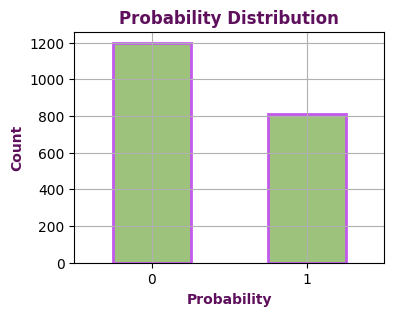

In [176]:
plt.figure(figsize=(4,3))
sns.countplot(
    data=df, 
    x='Potability',
    color="#9DCE6F",
    edgecolor="#C459EE",
    linewidth= 2,
    width=0.5
)
plt.title("Probability Distribution", color="#5E105C", fontweight='bold')
plt.xlabel('Probability', color="#5E105C", fontweight='bold')
plt.ylabel('Count', color="#5E105C", fontweight='bold')
plt.grid(True)
plt.show()

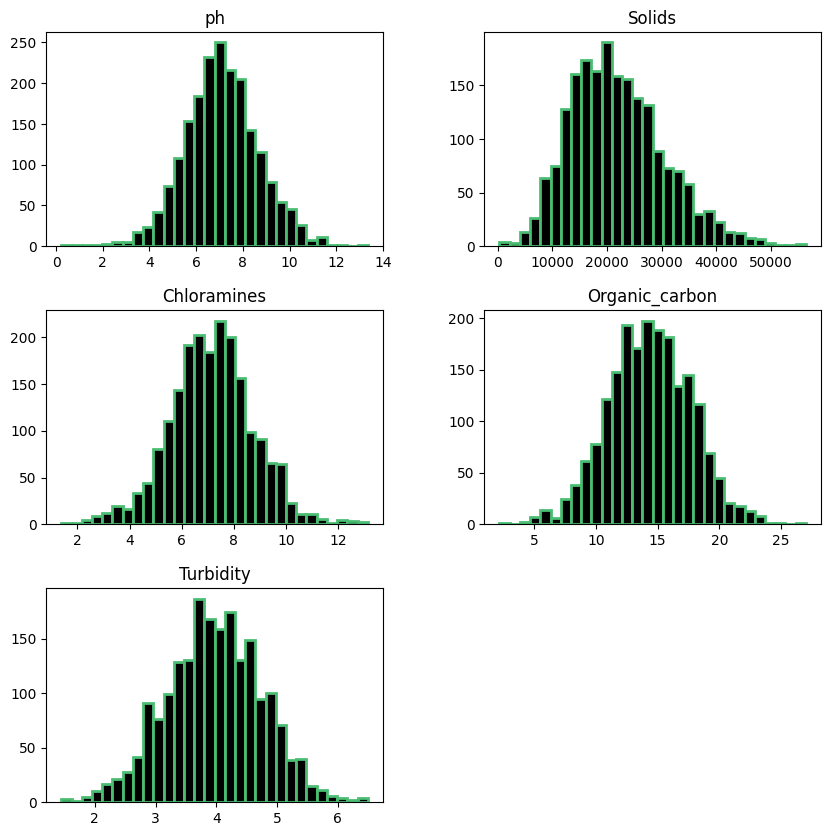

In [177]:
df[['ph', 'Solids', 'Chloramines', 'Organic_carbon', 'Turbidity']].hist(bins=30, figsize=(10,10), grid=False, linewidth=2, color='black', edgecolor="#4ABD72")
plt.show()

In [178]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

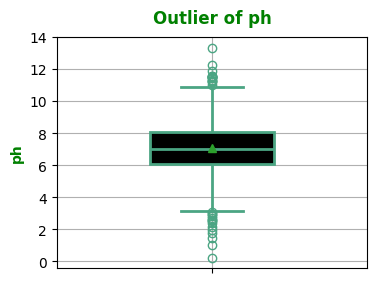

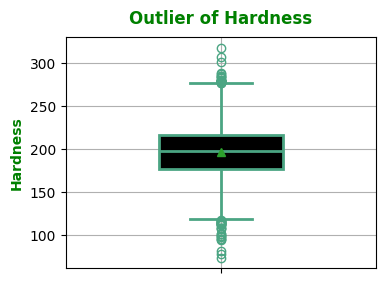

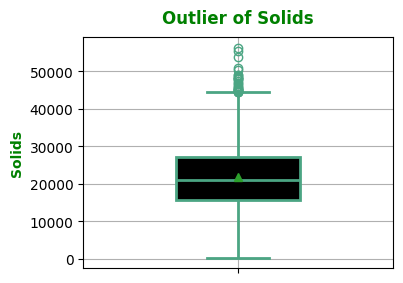

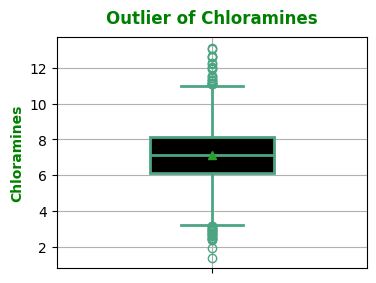

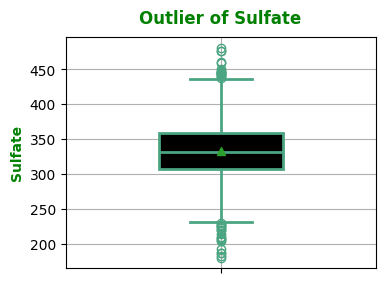

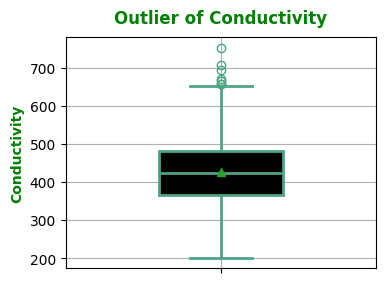

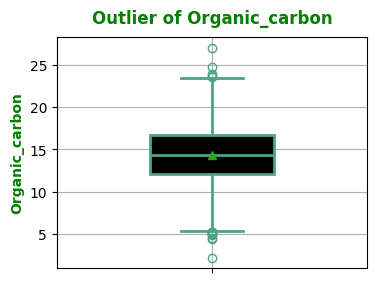

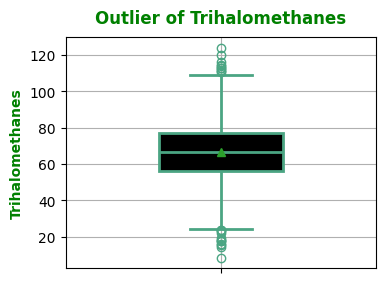

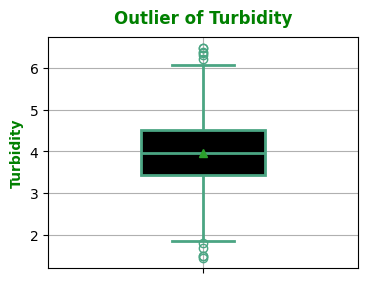

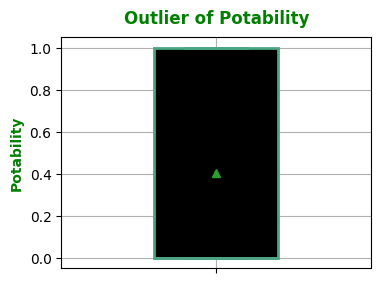

In [179]:
for col in df.columns:
    plt.figure(figsize=(4,3))
    sns.boxplot(
        df[col],
        color='black',
        linewidth=2,
        linecolor="#4BA583",
        width=0.4,
        showmeans=True
    )
    plt.title(f'Outlier of {col}', color='green', fontweight='bold', pad=10)
    plt.ylabel(col, color='green', fontweight='bold')
    plt.grid(True)
    plt.show()

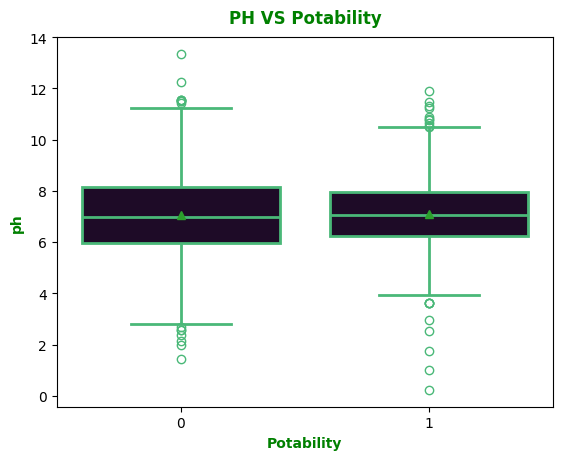

In [180]:
sns.boxplot(
    x='Potability', 
    y='ph', 
    data=df, 
    color="#20062C",
    linecolor="#4AB878",
    linewidth=2,
    showmeans=True
)
plt.title('PH VS Potability', color='green', fontweight='bold', pad=10)
plt.xlabel('Potability', color='green', fontweight='bold')
plt.ylabel('ph', color='green', fontweight='bold')
plt.show()

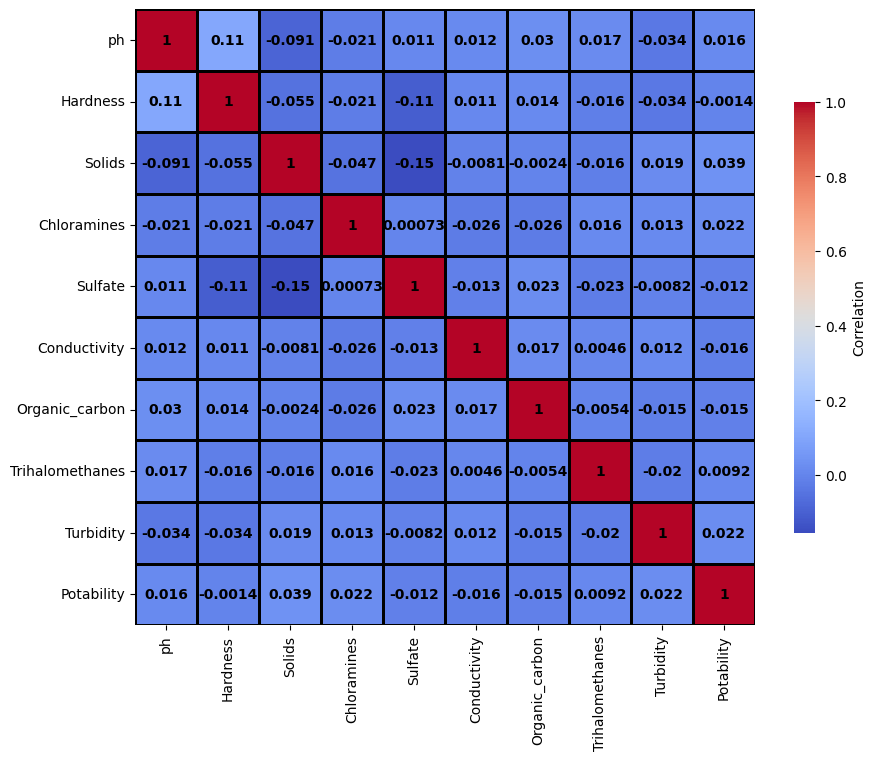

In [181]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(), 
    annot=True,
    cmap='coolwarm',
    linewidths=2,
    linecolor='black',
    annot_kws={
        'color':"black",
        'fontweight': 'bold',
    },
    cbar=True,
    cbar_kws={
        'shrink': 0.7,
        'label': 'Correlation'
    }
)
plt.show()

In [182]:
# Separate features (X) and target variable (y) by dropping the target column from the DataFrame
x = df.drop(['Potability'], axis=1)
y = df[['Potability']]

In [183]:
# Standardize each feature column using StandardScaler to bring them to zero mean and unit variance
stands = StandardScaler()

for col4 in x.columns:
    x[col4] = stands.fit_transform(x[[col4]])  # Scale each column independently

x.head()  # Display the first few rows of the scaled feature set

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
3,0.788927,0.564999,0.013848,0.582828,0.575930,-0.783084,1.226256,2.111063,0.844347
4,1.284238,-0.454729,-0.455321,-0.373106,-0.565749,-0.347526,-0.843124,-2.139123,0.134745
5,-0.956529,-0.233699,0.795550,0.257725,-0.161766,-1.809242,-1.793400,-0.713773,-1.807312
6,2.007055,1.597797,0.795669,0.237845,1.474058,-1.769785,-0.171783,1.132334,-1.662134
7,0.992736,0.227503,-0.955554,-1.626588,-0.732445,0.596814,-0.600771,-0.223700,0.552987


In [184]:
# Split the dataset into training and testing sets with 80% data for training and 20% for testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [185]:
# Display the first few rows of the training feature set
xtrain.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
935,2.110703,0.151792,-0.454926,-0.816148,0.139119,-1.117543,-0.012413,-0.263602,1.219298
904,-0.723115,-1.087889,-0.580780,-0.689507,0.830941,0.304393,0.601501,-0.250446,0.131057
1727,0.203182,1.902693,-0.390736,-1.036274,0.159626,-0.889657,0.186030,0.411256,-0.224033
1899,-0.129165,0.575986,-0.161428,1.199535,-0.291076,-1.483092,-0.566628,0.826897,0.936236
2206,1.098820,0.918131,0.204421,-2.956412,1.834373,0.254567,-0.005973,-1.467307,-0.256447


In [186]:
# Display the first few rows of the training target variable
ytrain.head()

,Potability
935,0
904,0
1727,0
1899,1
2206,0


In [187]:
# Get the dimensions of the training target variable (rows, columns)
ytrain.shape

(1406, 1)

In [188]:
# Apply SMOTE to the training set to balance the target classes by oversampling the minority class
smote = SMOTE()
xtrain_res, ytrain_res = smote.fit_resample(xtrain, ytrain)

# Check the shape of the resampled training target variable
ytrain_res.shape

(1696, 1)

# Feature Importance (Grid Search) with resampling

In [189]:
# Initialize a Decision Tree classifier with default parameters
dect = DecisionTreeClassifier(random_state=42)

In [190]:
# Define a grid of hyperparameters for tuning the Decision Tree classifier
param_grid = {
    'criterion': ['gini', 'entropy'],                # Function to measure the quality of a split
    'max_depth': [None, 3, 5, 7, 10],               # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],            # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],             # Minimum samples required to be at a leaf node (note: typo in key)
    'splitter': ['best', 'random'],                 # Strategy used to choose the split at each node
    'ccp_alpha': [0.0, 0.001, 0.01, 1]             # Complexity parameter for Minimal Cost-Complexity Pruning
}

In [191]:
# Initialize GridSearchCV to find the best hyperparameters for the Decision Tree classifier
# Uses 5-fold cross-validation, evaluates by accuracy, and runs in parallel on all CPU cores
gridscv = GridSearchCV(
    estimator=dect,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [192]:
gridscv

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
# Fit the GridSearchCV object on the resampled training data to find the best Decision Tree model
model = gridscv.fit(xtrain_res, ytrain_res)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


In [ ]:
# Evaluate the accuracy of the best Decision Tree model on the resampled training data
model.score(xtrain_res, ytrain_res)

0.9858490566037735

In [ ]:
# Evaluate the accuracy of the best Decision Tree model on the unseen test data
model.score(xtest, ytest)

0.603648424543947

In [ ]:
# Predict the target values for the test set using the trained Decision Tree model
pred_y = model.predict(xtest)

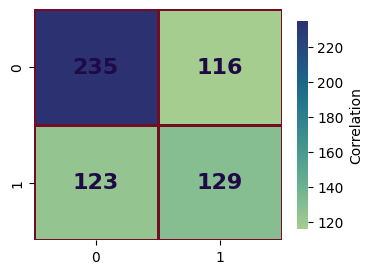

In [ ]:
# Compute and visualize the confusion matrix for the test set predictions
cm = confusion_matrix(ytest, pred_y)

# Set up the figure size for the heatmap
plt.figure(figsize=(4,3))

# Plot the confusion matrix as a heatmap with annotations and custom styling
sns.heatmap(
    cm, 
    annot=True,               # Show numbers in each cell
    fmt='g',                  # Display numbers as integers
    cmap='crest',             # Color map for the heatmap
    linewidths=2,             # Width of lines separating cells
    linecolor="#750C26",      # Color of lines separating cells
    annot_kws={               # Annotation text properties
        'color':"#1F0947",
        'fontweight': 'bold',
        'fontsize':16
    },
    cbar=True,                # Display color bar
    cbar_kws={                # Color bar styling
        'shrink':0.9,
        'label':'Correlation',
    }
)        

# Display the heatmap
plt.show()

In [ ]:
# Retrieve details of the best Decision Tree model found by GridSearchCV
best_model = model.best_estimator_  # The estimator with the best found hyperparameters
best_param = model.best_params_     # Dictionary of the best hyperparameters
best_score = model.best_score_      # Best cross-validation score achieved during GridSearch
best_index = model.best_index_      # Index of the best score in the list of all grid search results

In [ ]:
# Print the details of the best Decision Tree model after GridSearchCV
print("Best Model", best_model)      # Display the best estimator object
print("Best Parameter", best_param)  # Display the best hyperparameters
print("Best Score", best_score)      # Display the highest cross-validation score
print("Best Index", best_index)      # Display the index of the best score in GridSearch results

Best Model DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42)
Best Parameter {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Best Score 0.6515339233038349
Best Index 162


In [ ]:
# Get the predicted probabilities for the positive class (class 1) on the test set
pred_y_proba = model.predict_proba(xtest)[:, 1]

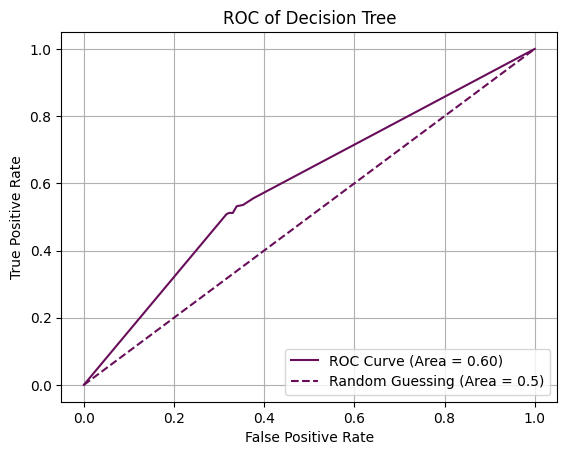

In [ ]:
# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for ROC
fpr, tpr, thresholds = roc_curve(ytest, pred_y_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = roc_auc_score(ytest, pred_y_proba)

# Plot the ROC curve with custom styling
plt.plot(fpr, tpr, color="#680D59", label=f"ROC Curve (Area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='#680D59', linestyle='--', label='Random Guessing (Area = 0.5)')

# Set axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC of Decision Tree")

# Display legend and grid
plt.legend(loc='lower right')
plt.grid(True)

# Show the ROC plot
plt.show()


# Feature Importance (Random Search) with resampling

In [ ]:
parameter = {
    'criterion':['gini', 'entropy'],
    'max_depth':[None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter':['best', 'random']
}

In [ ]:
randscv = RandomizedSearchCV(
    estimator=dect,
    param_distributions=parameter,
    n_iter=50,
    cv=5,
    verbose=1, 
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

In [ ]:
model2 = randscv.fit(xtrain_res, ytrain_res)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
model2.score(xtrain_res, ytrain_res)

0.9711084905660378

In [ ]:
model2.score(xtest, ytest)

0.5986733001658375

In [ ]:
pred_y2 = model2.predict(xtest)

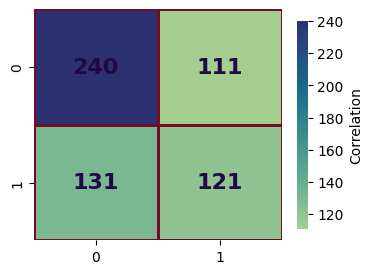

In [ ]:
# Compute and visualize the confusion matrix for the test set predictions
cm2 = confusion_matrix(ytest, pred_y2)

# Set up the figure size for the heatmap
plt.figure(figsize=(4,3))

# Plot the confusion matrix as a heatmap with annotations and custom styling
sns.heatmap(
    cm2, 
    annot=True,               # Show numbers in each cell
    fmt='g',                  # Display numbers as integers
    cmap='crest',             # Color map for the heatmap
    linewidths=2,             # Width of lines separating cells
    linecolor="#750C26",      # Color of lines separating cells
    annot_kws={               # Annotation text properties
        'color':"#1F0947",
        'fontweight': 'bold',
        'fontsize':16
    },
    cbar=True,                # Display color bar
    cbar_kws={                # Color bar styling
        'shrink':0.9,
        'label':'Correlation',
    }
)        

# Display the heatmap
plt.show()

In [ ]:
cl = classification_report(ytest, pred_y2)
print(cl)

              precision    recall  f1-score   support

           0       0.65      0.68      0.66       351
           1       0.52      0.48      0.50       252

    accuracy                           0.60       603
   macro avg       0.58      0.58      0.58       603
weighted avg       0.59      0.60      0.60       603



In [ ]:
acc = accuracy_score(ytest, pred_y2)
acc

0.5986733001658375

In [ ]:
best_model2 = model2.best_estimator_
best_param2 = model2.best_params_
best_score2 = model2.best_score_
best_index2 = model2.best_index_

In [ ]:
print("Best Model", best_model2)      # Display the best estimator object
print("Best Parameter", best_param2)  # Display the best hyperparameters
print("Best Score", best_score2)      # Display the highest cross-validation score
print("Best Index", best_index2)      # Display the index of the best score in GridSearch results

Best Model DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, random_state=42)
Best Parameter {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
Best Score 0.6444716293597085
Best Index 2


In [ ]:
pred_y_proba2 = model2.predict_proba(xtest)[:, 1]

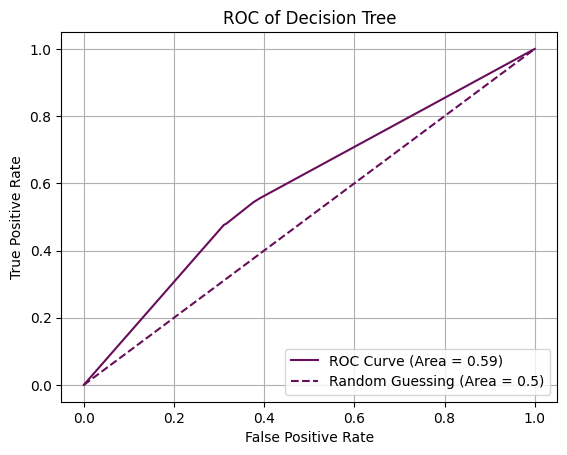

In [ ]:
# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for ROC
fpr, tpr, thresholds = roc_curve(ytest, pred_y_proba2)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = roc_auc_score(ytest, pred_y_proba2)

# Plot the ROC curve with custom styling
plt.plot(fpr, tpr, color="#680D59", label=f"ROC Curve (Area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='#680D59', linestyle='--', label='Random Guessing (Area = 0.5)')

# Set axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC of Decision Tree")

# Display legend and grid
plt.legend(loc='lower right')
plt.grid(True)

# Show the ROC plot
plt.show()

# # Feature Importance (Grid Search) withOUT resampling

In [ ]:
# Fit GridSearchCV on the original (non-SMOTE) training data to train and tune the Decision Tree model
model3 = gridscv.fit(xtrain, ytrain)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


In [ ]:
model3

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
# Evaluate the accuracy of the tuned Decision Tree model on the original training data
model3.score(xtrain, ytrain)

0.7155049786628734

In [ ]:
# Evaluate the accuracy of the tuned Decision Tree model on the test dataset
model3.score(xtest, ytest)

0.6301824212271974

In [ ]:
# Predict target values for the test set using the tuned Decision Tree model (without SMOTE)
pred_y3 = model3.predict(xtest)

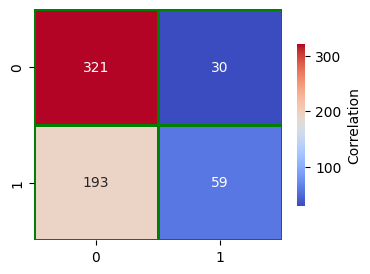

In [ ]:
# Compute and visualize the confusion matrix for the Decision Tree model predictions (without SMOTE)
cm3 = confusion_matrix(ytest, pred_y3)

# Set the figure size for the confusion matrix heatmap
plt.figure(figsize=(4,3))

# Plot the confusion matrix using a heatmap with custom styling
sns.heatmap(
    cm3,
    annot=True,            # Display count values inside the cells
    cmap='coolwarm',       # Use a coolwarm color palette
    linewidths=2,          # Set the width of lines between cells
    fmt='g',               # Show values as integers
    linecolor='green',     # Set line color between cells
    cbar=True,             # Show color bar
    cbar_kws={             # Customize the color bar
        'shrink':0.7,
        'label': 'Correlation'
    }
)

# Display the confusion matrix plot
plt.show()

In [ ]:
# Extract and print the best model details obtained from GridSearchCV (without SMOTE)
best_model3 = model3.best_estimator_  # Best Decision Tree model
best_score3 = model3.best_score_      # Best cross-validation score
best_param3 = model3.best_params_     # Best hyperparameters
best_index3 = model3.best_index_      # Index of the best parameter set

print("Best Model:", best_model3)     # Print the best estimator
print("Best Score: ", best_score3)    # Print the best CV score
print("Best param: ", best_param3)    # Print the best hyperparameters
print("Best index: ", best_index3)    # Print the index of the best result

Best Model: DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)
Best Score:  0.6365715151056259
Best param:  {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Best index:  426


In [ ]:
pred_y_proba3 = model3.predict_proba(xtest)[:, 1]

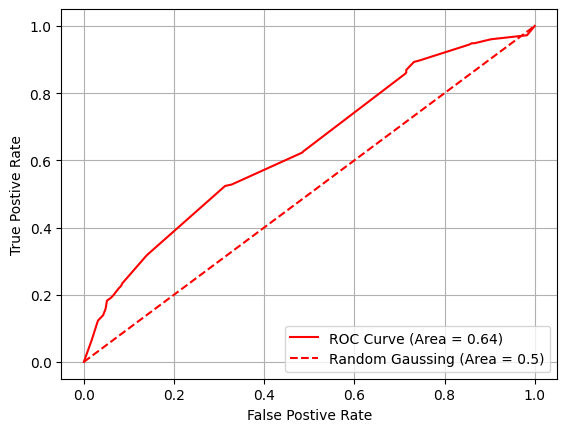

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, pred_y_proba3)
roc_auc = roc_auc_score(ytest, pred_y_proba3)

plt.plot(fpr, tpr, color='red', label=f"ROC Curve (Area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Gaussing (Area = 0.5)')
plt.xlabel("False Postive Rate")
plt.ylabel("True Postive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# # Feature Importance (Random Search) withOUT resampling

In [ ]:
model4 = randscv.fit(xtrain, ytrain)
model4

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
model4.score(xtrain, ytrain)

0.6756756756756757

In [ ]:
model4.score(xtest, ytest)

0.6451077943615257

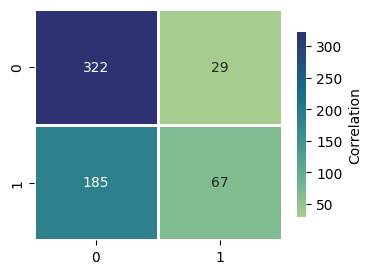

In [ ]:
pred_y4 = model4.predict(xtest)
cm4 = confusion_matrix(ytest, pred_y4)
plt.figure(figsize=(4,3))
sns.heatmap(
    cm4,
    annot=True,
    cmap='crest',
    fmt='g',
    cbar=True,
    cbar_kws={
        'shrink': 0.8,
        'label': 'Correlation'
    },

    linecolor='white',
    linewidths=2
)
plt.show()

In [ ]:
# Extract and print the best model details obtained from RandomSearchCV (without SMOTE)
best_model3 = model3.best_estimator_  # Best Decision Tree model
best_score3 = model3.best_score_      # Best cross-validation score
best_param3 = model3.best_params_     # Best hyperparameters
best_index3 = model3.best_index_      # Index of the best parameter set

print("Best Model:", best_model3)     # Print the best estimator
print("Best Score: ", best_score3)    # Print the best CV score
print("Best param: ", best_param3)    # Print the best hyperparameters
print("Best index: ", best_index3)    # Print the index of the best result

Best Model: DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)
Best Score:  0.6365715151056259
Best param:  {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Best index:  426


In [ ]:
pred_y_proba4 = model4.predict_proba(xtest)[:, 1]

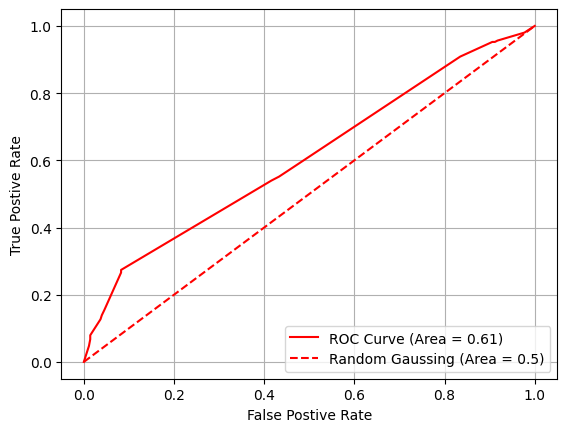

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, pred_y_proba4)
roc_auc = roc_auc_score(ytest, pred_y_proba4)

plt.plot(fpr, tpr, color='red', label=f"ROC Curve (Area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Gaussing (Area = 0.5)')
plt.xlabel("False Postive Rate")
plt.ylabel("True Postive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

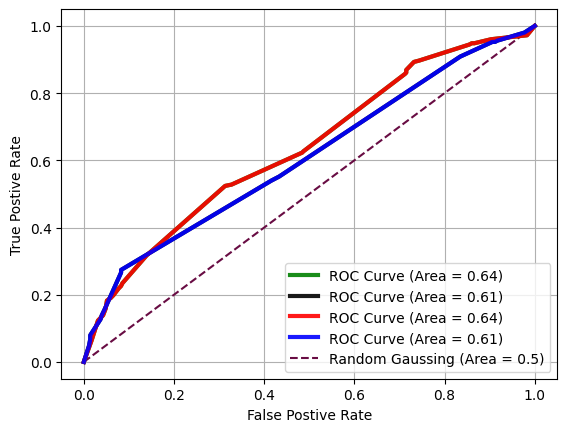

In [ ]:
pred_y_proba1 = model.predict_proba(xtest)[:, 1]
fpr1, tpr1, _ = roc_curve(ytest, pred_y_proba1)
roc_auc1 = roc_auc_score(ytest, pred_y_proba1)

pred_y_proba12 = model2.predict_proba(xtest)[:, 1]
fpr2, tpr2, _ = roc_curve(ytest, pred_y_proba12)
roc_auc2 = roc_auc_score(ytest, pred_y_proba12)

pred_y_proba13 = model3.predict_proba(xtest)[:, 1]
fpr3, tpr3, _ = roc_curve(ytest, pred_y_proba13)
roc_auc3 = roc_auc_score(ytest, pred_y_proba13)

pred_y_proba14 = model4.predict_proba(xtest)[:, 1]
fpr4, tpr4, _ = roc_curve(ytest, pred_y_proba14)
roc_auc4 = roc_auc_score(ytest, pred_y_proba14)

plt.plot(fpr1, tpr1, color='green',linewidth=3, alpha=0.9, zorder=3, label=f"Model1 (Area = {roc_auc1:.2f})")
plt.plot(fpr2, tpr2, color='black',linewidth=3, alpha=0.9, zorder=3, label=f"Model2 (Area = {roc_auc2:.2f})")
plt.plot(fpr3, tpr3, color='red',linewidth=3, alpha=0.9, zorder=3, label=f"Model3 (Area = {roc_auc3:.2f})")
plt.plot(fpr4, tpr4, color='blue',linewidth=3, alpha=0.9, zorder=3, label=f"Model4 (Area = {roc_auc4:.2f})")

plt.plot([0,1], [0,1], color="#680C43", linestyle='--', label='Random Gaussing (Area = 0.5)')

plt.xlabel("False Postive Rate")
plt.ylabel("True Postive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
print("Model1 unique proba:", np.unique(pred_y_proba1))
print("Model2 unique proba:", np.unique(pred_y_proba12))

Model1 unique proba: [0.         0.02409639 0.06896552 0.09090909 0.1        0.16239316
 0.16666667 0.20588235 0.25       0.28571429 0.32152589 0.33333333
 0.35135135 0.45454545 0.48898678 0.49514563 0.55555556 0.58333333
 0.63636364 0.71428571 0.83333333 0.85714286 0.88888889 0.91666667
 0.92307692 0.92592593 1.        ]
Model2 unique proba: [0.         0.05084746 0.14285714 0.2        0.21212121 0.32432432
 0.36170213 0.4        0.45014245 0.5        0.58163265 0.6
 0.625      0.66666667 0.69642857 0.8        0.875      1.        ]
